# H02A5A Computer Vision Project - Incisor Segmentation

## Imports

In [1]:
%matplotlib inline
import numpy as np
import cv2
from incisorseg.dataset import Dataset,LeaveOneOutSplitter,load_image,load_landmark
from incisorseg.utils import *
from asm.shape import Shape, ShapeList
from asm.shapemodel import ShapeModel
from asm.greymodel import GreyModel
from asm.model import ActiveShapeModel

## Reading the dataset

In [2]:
data = Dataset('../data/')

## Sample plots

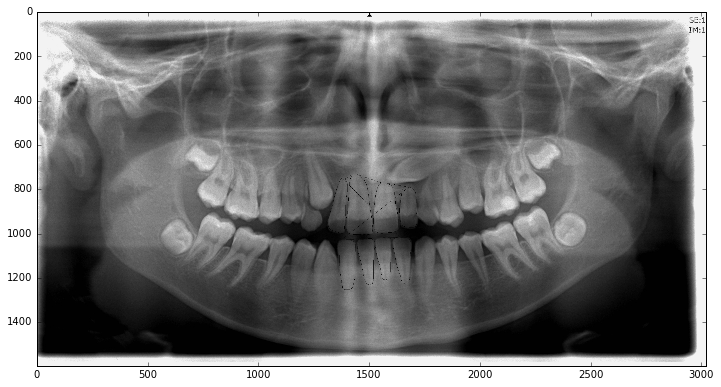

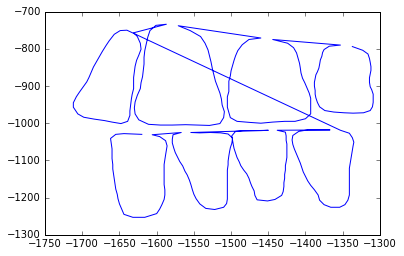

(1597, 3023)


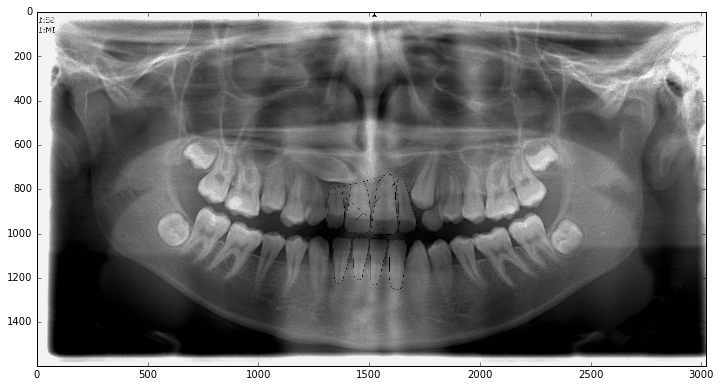

In [3]:
img,mimg = data.get_training_images([0])
lc,mlc = data.get_training_image_landmarks([0],Dataset.ALL_TEETH)
imshow2(overlay_shapes_on_image(img[0],lc))
plot_shapes(mlc)
imshow2(overlay_shapes_on_image(mimg[0],mlc))
print img[0].shape

## Shape Model
All 8 teeth

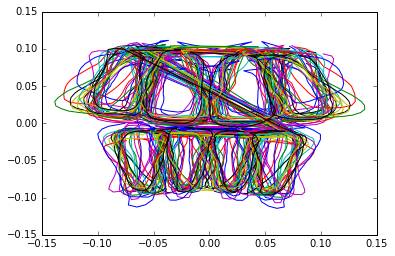

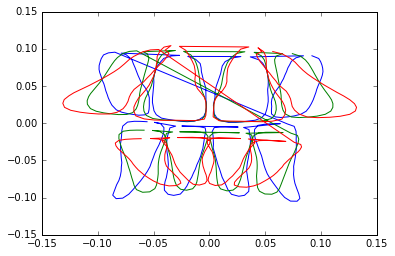

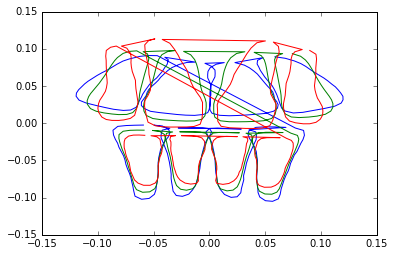

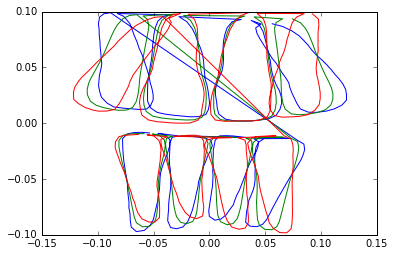

In [4]:
lc,mlc = data.get_training_image_landmarks(Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH)
landmarks = lc.concatenate(mlc)
model = ShapeModel(ShapeList(landmarks))
plot_shapes(model.aligned_shapes())
#plot_shapes([model.mean_shape()])
plot_shapes(model.mode_shapes(1))
plot_shapes(model.mode_shapes(2))
plot_shapes(model.mode_shapes(3))

### Some edge detection and pyramids

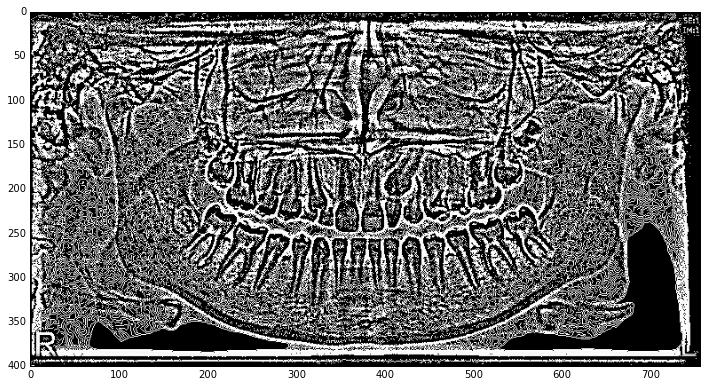

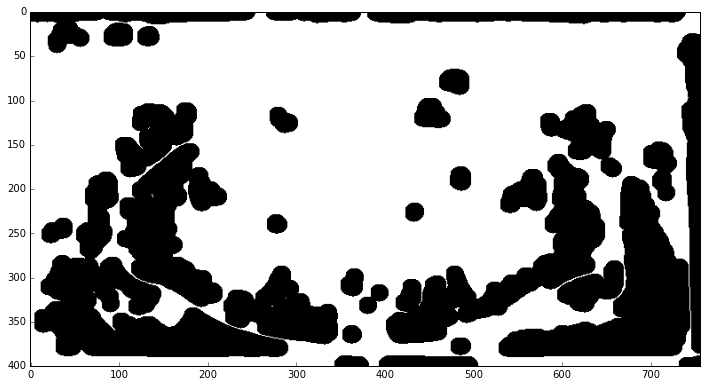

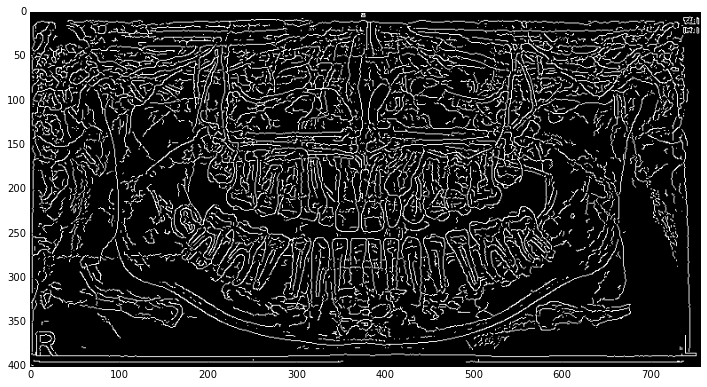

In [5]:
sample = cv2.pyrDown(cv2.pyrDown(data.get_extra_images([0])[0]))#[650:1300,1200:1800]
imshow2(cv2.Laplacian(cv2.bilateralFilter(sample,5,30,30),2))
imshow2(cv2.morphologyEx(cv2.Canny(cv2.bilateralFilter(sample,9,30,30),20,20),cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(20,20))))
imshow2(cv2.Canny(cv2.bilateralFilter(sample,5,30,30),10,20))

#### Shape normals

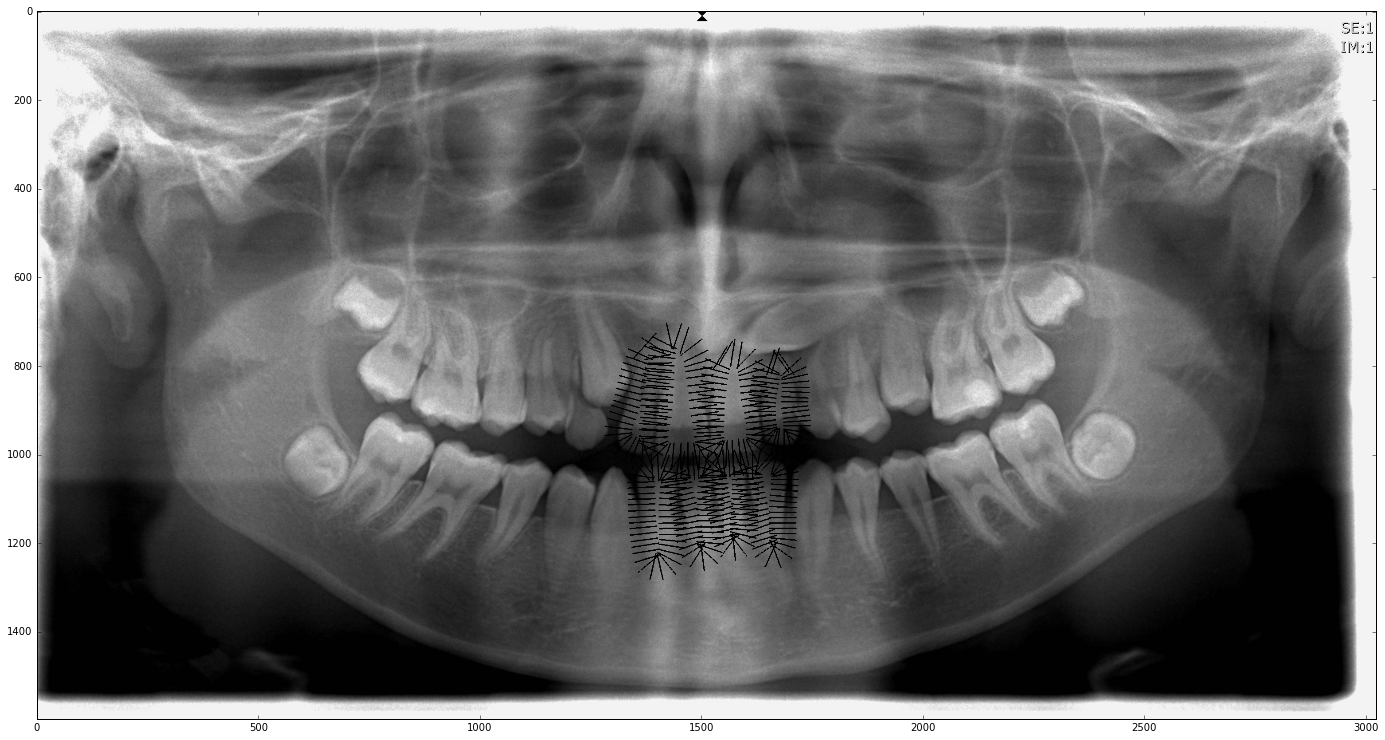

In [6]:
img,_ = data.get_training_images([0])
l,_ = data.get_training_image_landmarks([0],Dataset.ALL_TEETH)
shape = l.tolist()[0]
normal_pixels = []
for i in range(shape.size()):
    generator = shape.get_normal_at_point_generator(i, 2)
    for increment in range(-30, 31):
        coordinates = np.int32(np.round(generator(increment)))
        normal_pixels.append(coordinates.tolist())
imshow2(overlay_points_on_image(img[0],normal_pixels),width=24,height=24)

#### Grey Level pixels for the shape normals

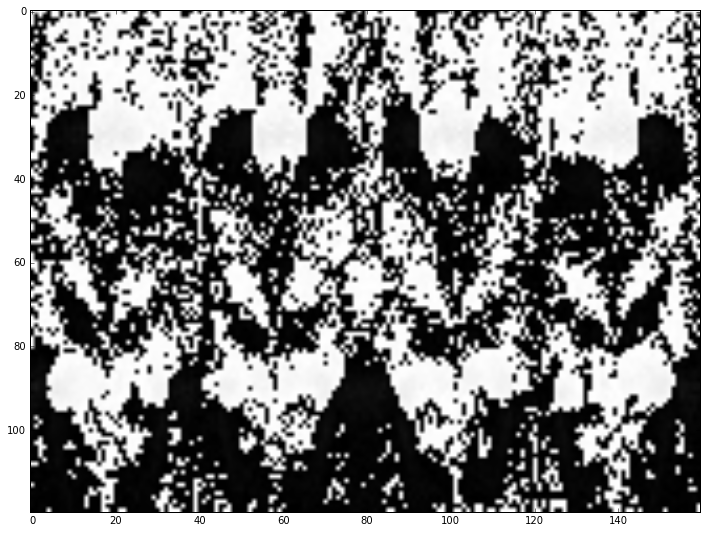

In [7]:
img,mimg = data.get_training_images(Dataset.ALL_TRAINING_IMAGES)
l,ml = data.get_training_image_landmarks(Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH)
images = img + mimg
shapes = l.concatenate(ml)
greymodel = GreyModel(images,shapes,number_of_pixels_model=30,normalize=True,use_gradient=True)
img = np.array([greymodel.grey_model_point(point_index).mean() for point_index in range(greymodel.size())])
img = np.concatenate((img[:][:160],img[:][160:]),axis=1)
imshow2(np.uint8(np.round(100*img.T),width=24,height=24))

#### Fun with pyramids

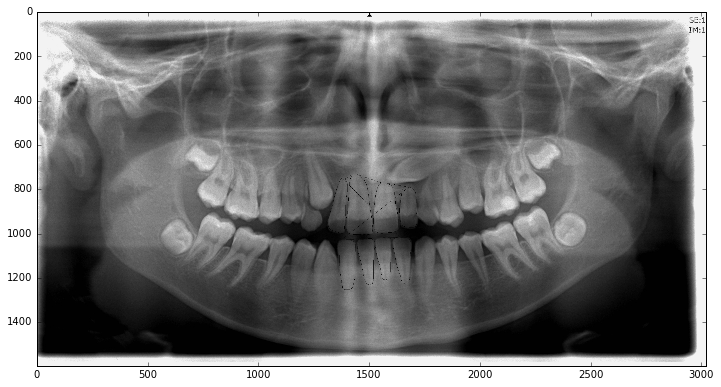

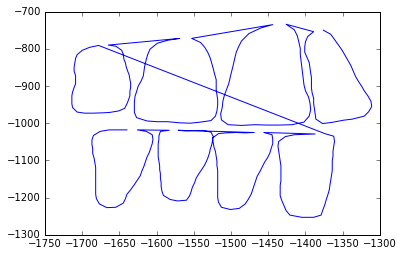

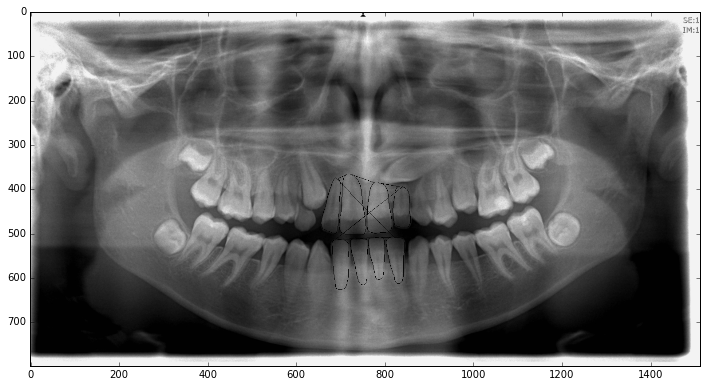

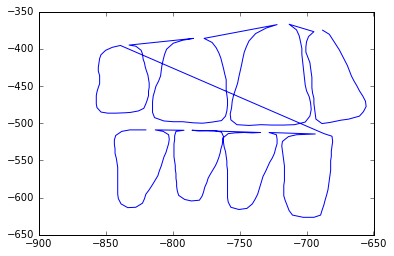

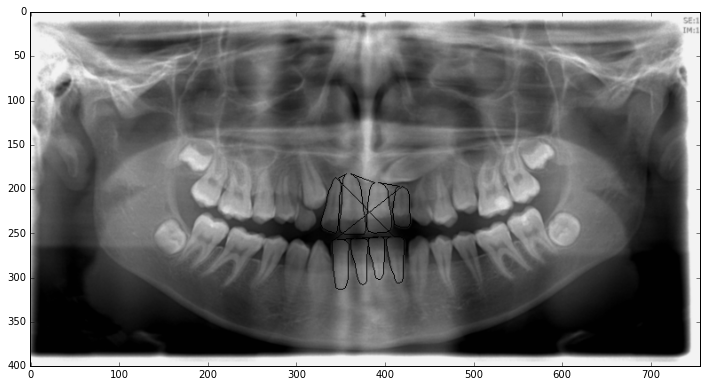

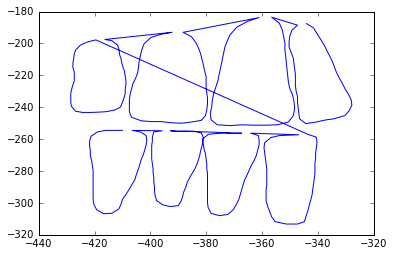

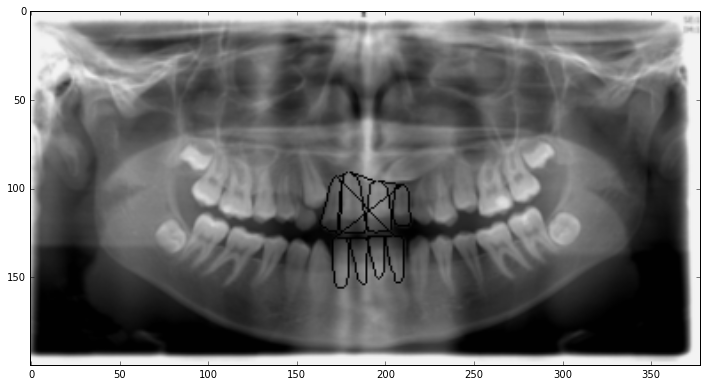

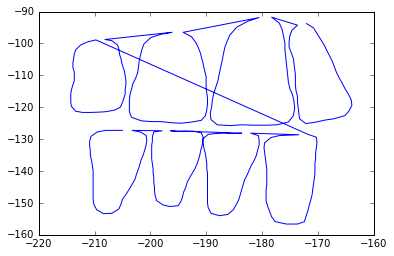

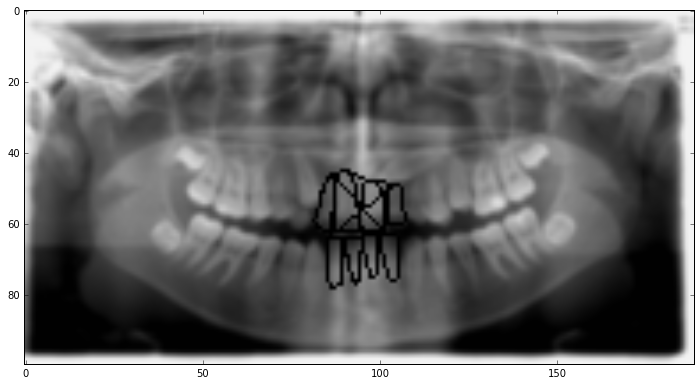

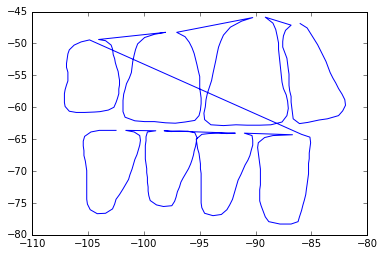

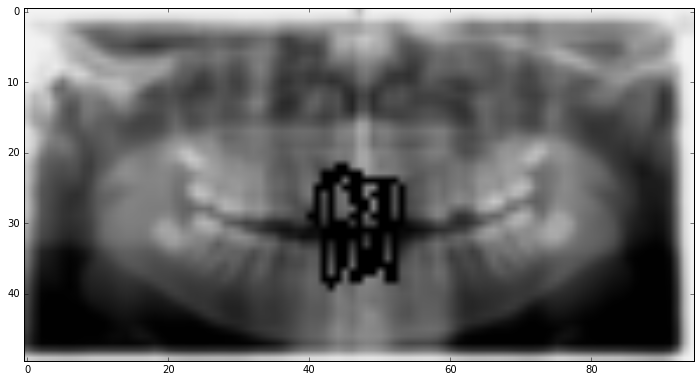

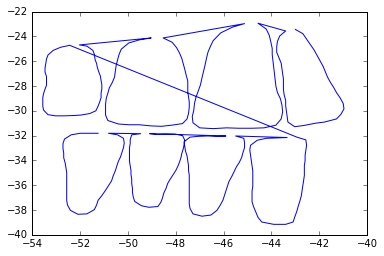

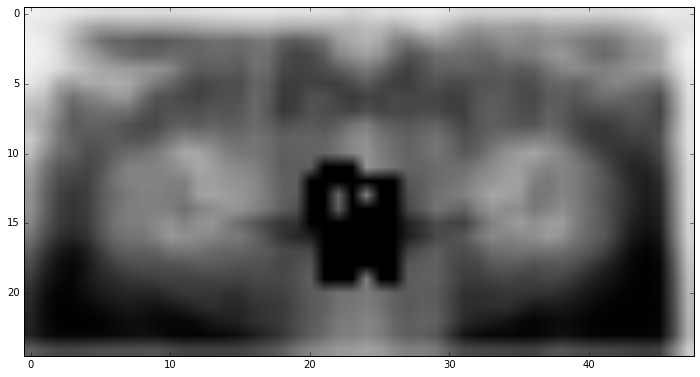

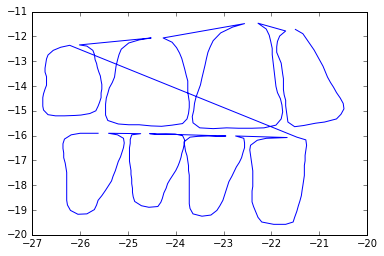

In [8]:
pimg = images[0]
shape = shapes[0]
for i in range(7):
    imshow2(overlay_shapes_on_image(pimg,[shape]))
    plot_shapes([shape])
    pimg = cv2.pyrDown(pimg)
    shape = shape.pyr_down()

#### Leave 1 out CV

In [9]:
i = 0
for split in LeaveOneOutSplitter(data):
    if i > 0:
        break
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    model = ActiveShapeModel(training_images,training_landmarks)
    new_shape_combined = model.fit(test_image,1e-3,10)
    print split.get_dice_error_on_test(test_landmark)
    print split.get_dice_error_on_test(model.starting_shape())
    print split.get_dice_error_on_test(new_shape_combined)
    imshow2(overlay_shapes_on_image(test_image,[new_shape_combined.round()]))
    plot_shapes([new_shape_combined])
    i +=1

[ 1513.95520349   936.29186259]
[ 49.02524448  58.65234052]
[ 43.51399532  25.42316886]
[ 34.93940451   6.07772619]
[ 24.62773681   0.22414746]
[ 15.44596871   0.        ]


asm/shape.py:111: RuntimeWarning: invalid value encountered in divide
  return Shape(self._data / self.norm())


LinAlgError: SVD did not converge

In [ ]:
starting_shape = model.mean_shape_projected()
for pimg in images:
    starting_shape_image = starting_shape
    for i in range(4):
        if i==3:
            imshow2(overlay_shapes_on_image(pimg,[starting_shape_image.round()]))
        pimg = cv2.pyrDown(pimg)
        starting_shape_image = starting_shape_image.pyr_down()
